In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest, chi2
import statsmodels.api as sm
import numpy as np
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv (r'data_clean_4_21.csv')
# remove those without fips_code
data.dropna(subset = ["fips_code"], inplace=True)
data.dropna(subset = ["ICU.Bed.Occupancy.Rate"], inplace=True)
data.dropna(subset = ["population_20"], inplace=True)
#data.isnull().sum()
X = data.drop(['fips_code', 'date', 'county', 'State', 'Staffed.All.Beds', 'Staffed.ICU.Beds', 'Licensed.All.Beds',
       'All.Bed.Occupancy.Rate', 'ICU.Bed.Occupancy.Rate', 'Population', 'Population_2010',
       'Population..20..', 'Population..65..',
       'Staffed.All.Beds..Per.1000.People.',
       'Staffed.All.Beds..Per.1000.Adults..20...',
       'Staffed.All.Beds..Per.1000.Elderly..65...',
       'Staffed.ICU.Beds..Per.1000.People.',
       'Staffed.ICU.Beds..Per.1000.Adults..20...',
       'Staffed.ICU.Beds..Per.1000.Elderly..65...',
       'Licensed.All.Beds..Per.1000.People.',
       'Licensed.All.Beds..Per.1000.Adults..20...',
       'Licensed.All.Beds..Per.1000.Elderly..65...', 'county_x', 'County_Name', 'Area_name'], axis = 1)
X['state'] = X.state.factorize()[0]
X['Description'] = X.Description.factorize()[0]
X['peopleinpoverty2018'] = X.peopleinpoverty2018.factorize()[0]
X['medianhouseholdincome'] = X.medianhouseholdincome.factorize()[0]
Y_c = data['cases']
Y_d = data['deaths']
X_new = X.drop(['population'], axis = 1)

In [22]:
X_d = X[['population_20', 'population_65', 'icu_bed_occupancy_rate', 'licensed_all_beds', 'all_bed_occupancy_rate']]
X_train, X_valid, y_train, y_valid = train_test_split(X_new, Y_d, test_size = 0.7, random_state = 1)

## Gaussian Process Latent Variable Model

In [4]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats
#assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(1)

In [5]:
data = torch.tensor(X_new.values, dtype=torch.get_default_dtype())

In [27]:
data

tensor([[0.0000e+00, 3.0000e+01, 1.0000e+00,  ..., 2.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.2300e+02, 3.0000e+00,  ..., 2.0000e+00, 1.0000e+00,
         1.0000e+00],
        [0.0000e+00, 2.8000e+01, 0.0000e+00,  ..., 6.0000e+00, 2.0000e+00,
         2.0000e+00],
        ...,
        [5.0000e+01, 1.0000e+01, 0.0000e+00,  ..., 8.0000e+00, 1.3220e+03,
         1.3430e+03],
        [5.0000e+01, 6.2000e+01, 0.0000e+00,  ..., 8.0000e+00, 1.3230e+03,
         1.3440e+03],
        [5.0000e+01, 6.0000e+00, 0.0000e+00,  ..., 8.0000e+00, 1.3240e+03,
         1.3450e+03]])

In [7]:
X_gp = np.array(X_new).T

In [23]:
train_set = np.random.choice([True, False], len(Y_d), p = [0.75, 0.25])

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP

In [24]:
gp = GP()
gp.fit(X_d[train_set], Y_d[train_set])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [25]:
test_preds = gp.predict(X_d[~train_set])

Text(0.5,1,'Histogram of Residuals')

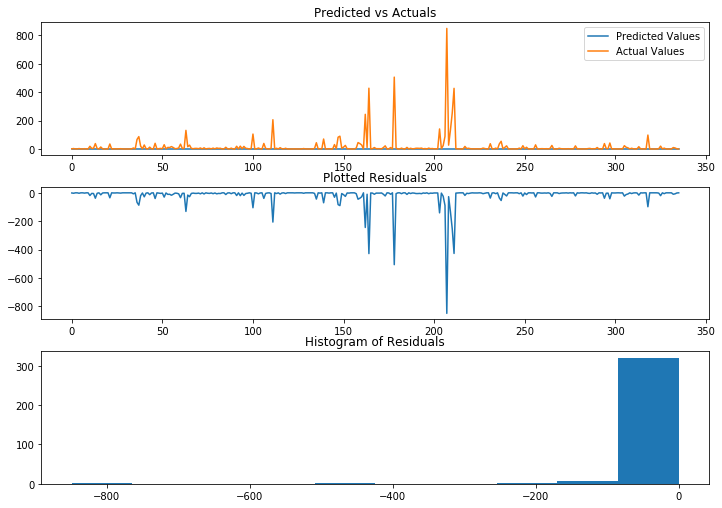

In [26]:
from matplotlib import pyplot as plt
f, ax = plt.subplots(figsize=(10, 7), nrows=3)
f.tight_layout()

ax[0].plot(range(len(test_preds)), test_preds, 
               label='Predicted Values');
ax[0].plot(range(len(test_preds)), Y_d[~train_set], 
               label='Actual Values');
ax[0].set_title("Predicted vs Actuals")
ax[0].legend(loc='best')

ax[1].plot(range(len(test_preds)), 
               test_preds - Y_d[~train_set]);
ax[1].set_title("Plotted Residuals")

ax[2].hist(test_preds - Y_d[~train_set]);
ax[2].set_title("Histogram of Residuals")

In [42]:
#normalize deaths
deaths = np.array(X["deaths"])
deaths = deaths / np.linalg.norm(deaths)
# test for 20
n = 20
training_points = np.atleast_2d([1, 5, 7, 10, 14, 16, 19]).T
np.random.seed(20)
train_deaths = deaths[training_points]

In [43]:
from sklearn.gaussian_process.kernels import RBF

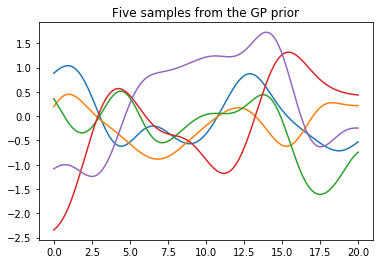

In [44]:
xs_train = training_points
ys_train = train_deaths
xs_test = np.atleast_2d(np.linspace(0, 20, 1000)).T
def rbf_kernel(x, y, alpha): 
    rbf = RBF(alpha)
    return rbf.__call__(x, y)
# Calculate the covariance matrix using the test data
K_ss = rbf_kernel(xs_test, xs_test, 2.)

# Get the "standard deviation" equivalent of the covariance matrix
# Note the small constant added to make the matrix positive semi-definite
L = np.linalg.cholesky(K_ss + 1e-10 * np.eye(len(xs_test)))

# Generate some normals (5 of them) 
normals = np.random.normal(size=(len(xs_test), 5))

# Dot them with the cholesky decomp. of the covariance matrix (scale them up)
f = np.dot(L, normals)

# Plot the 5 sampled functions.
plt.plot(xs_test, f)
plt.title('Five samples from the GP prior')
plt.show()